# Proyecto Demo Interactivo: “Análisis de Clientes y Ventas Minoristas”

#Objetivo <br>
Demostrar como se puede: <br>

*   Limpiar y transformar datos reales
*   Visualizar ventas y comportamientos
*   Segmentar clientes
*   Hacer predicciones simples con Machine Learning





##Introduccion <br>
## Proyecto: Análisis de Clientes y Ventas Minoristas
Autor: Gimenez Antoniow, Iara

En este proyecto, analizo datos de ventas minoristas utilizando Python, aplicando técnicas de análisis exploratorio, visualización, segmentación de clientes y predicción de ingresos. Es un ejemplo práctico orientado a roles de Data Analyst.



##Carga de Dataset

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

#  Configuración estética de gráficos
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Carga del dataset
df = pd.read_csv("retail_sales_dataset.csv")
df.head()


,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100


##Limpieza de Datos

In [7]:
# Convertimos fechas
df['Date'] = pd.to_datetime(df['Date'])

# Creamos columnas útiles
df['Mes'] = df['Date'].dt.month
df['Año'] = df['Date'].dt.year
df['Ingreso_total'] = df['Quantity'] * df['Price per Unit']
df.drop_duplicates(inplace=True)


##Analisis exploratorio

In [8]:
# Productos más vendidos
productos_vendidos = df.groupby('Product Category')['Quantity'].sum().sort_values(ascending=False)

# Ticket promedio mensual
df['Ticket_promedio'] = df['Total Amount'] / df['Quantity']
ticket_mes = df.groupby('Mes')['Ticket_promedio'].mean().round(2)

# Ventas por mes y producto
ventas_mes_producto = df.groupby(['Mes', 'Product Category'])['Quantity'].sum().unstack().fillna(0)


##Visualizaciones

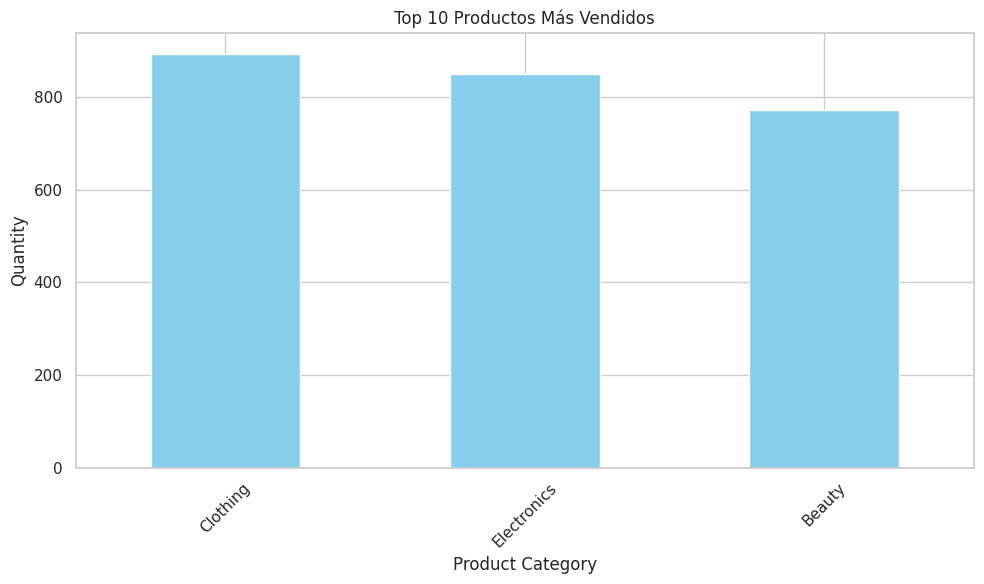

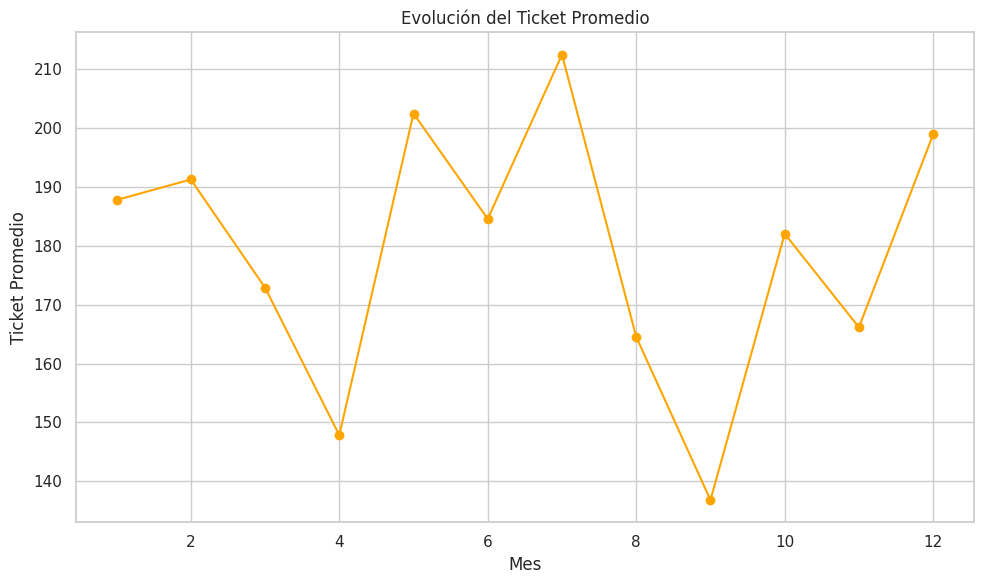

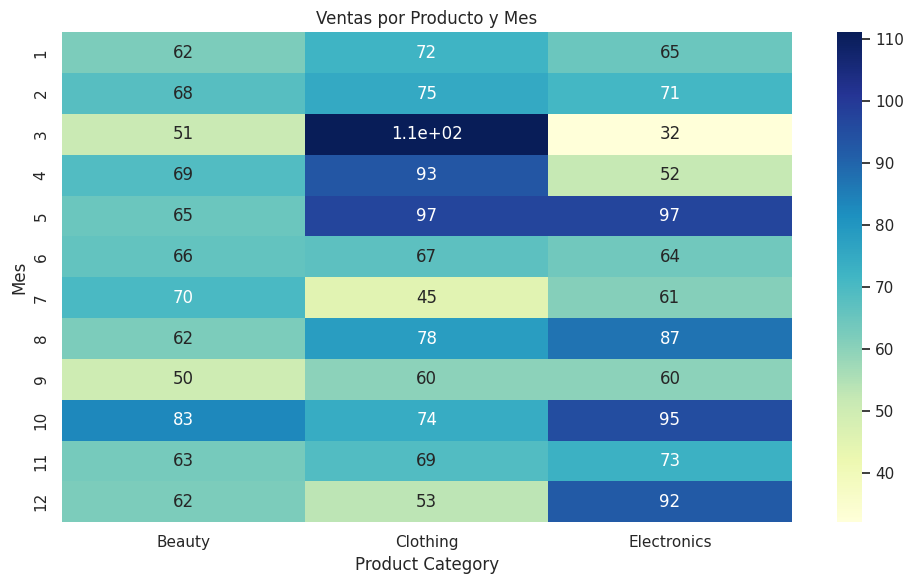

In [9]:
# Productos más vendidos
productos_vendidos.head(10).plot(kind='bar', color='skyblue', title='Top 10 Productos Más Vendidos')
plt.xlabel("Product Category"); plt.ylabel("Quantity"); plt.xticks(rotation=45)
plt.tight_layout(); plt.show()

# Ticket promedio por mes
ticket_mes.plot(marker='o', linestyle='-', color='orange', title="Evolución del Ticket Promedio")
plt.xlabel("Mes"); plt.ylabel("Ticket Promedio")
plt.tight_layout(); plt.show()

# Heatmap producto vs mes
sns.heatmap(ventas_mes_producto, cmap="YlGnBu", annot=True)
plt.title("Ventas por Producto y Mes"); plt.xlabel("Product Category"); plt.ylabel("Mes")
plt.tight_layout(); plt.show()


##Segmentacion de Clientes

In [11]:
clientes_df = df.groupby('Customer ID').agg({
    'Ingreso_total': 'sum',
    'Quantity': 'sum',
    'Date': ['min', 'max', 'nunique']
})

clientes_df.columns = ['Total_gastado', 'Total_compras', 'Primera_compra', 'Última_compra', 'Dias_diferentes']
clientes_df.reset_index(inplace=True)
clientes_df['Antigüedad'] = (clientes_df['Última_compra'] - clientes_df['Primera_compra']).dt.days
clientes_df['Ticket_promedio'] = clientes_df['Total_gastado'] / clientes_df['Total_compras']

def clasificar_cliente(row):
    if row['Total_gastado'] > 5000 and row['Antigüedad'] > 180:
        return 'Premium'
    elif row['Total_compras'] > 10:
        return 'Frecuente'
    elif row['Total_gastado'] < 1000:
        return 'Ocasional'
    else:
        return 'Regular'

clientes_df['Segmento'] = clientes_df.apply(clasificar_cliente, axis=1)


##Visualizacion de Clientes

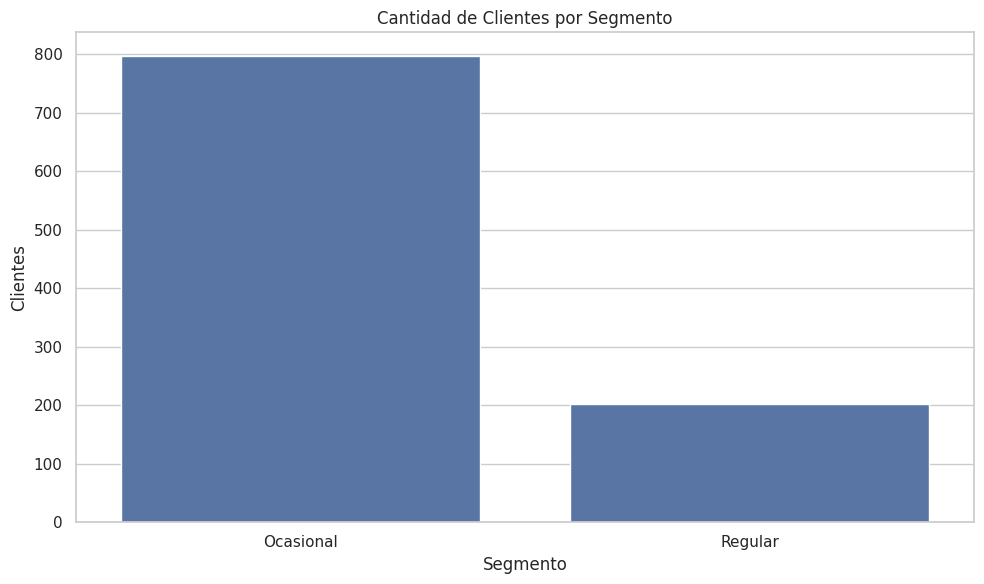

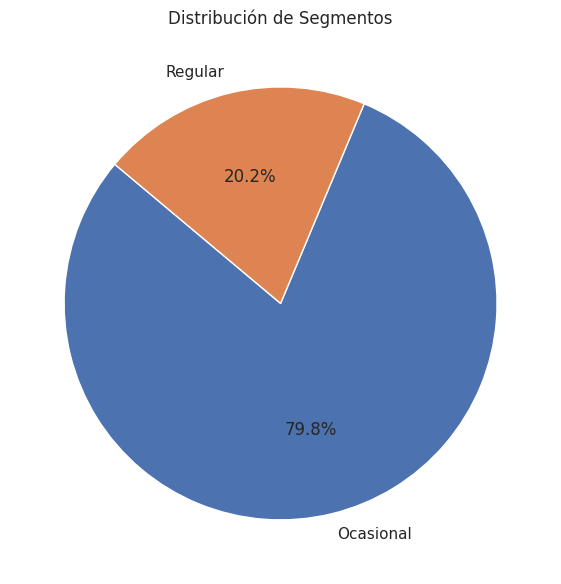

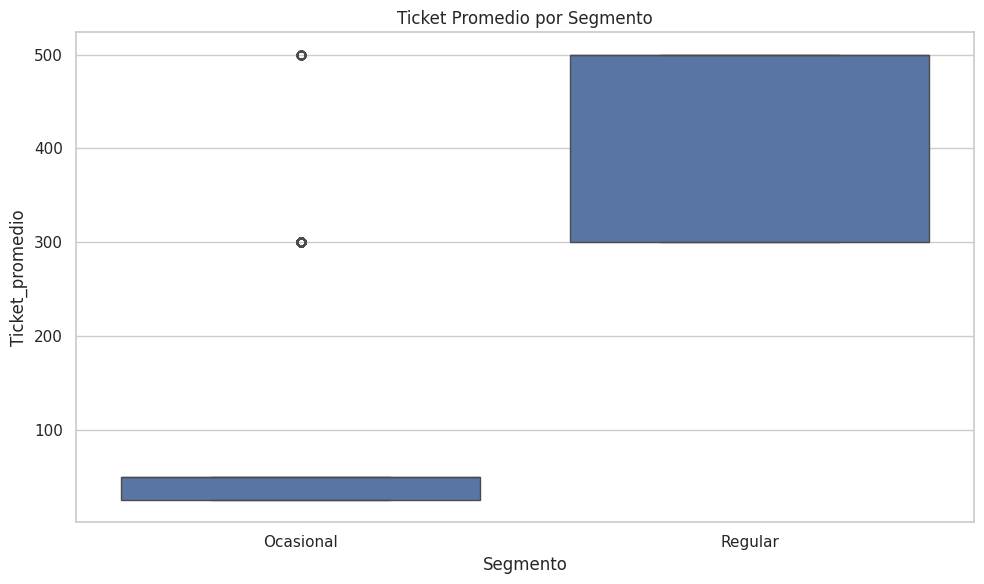

In [12]:
sns.barplot(x=clientes_df['Segmento'].value_counts().index, y=clientes_df['Segmento'].value_counts().values)
plt.title("Cantidad de Clientes por Segmento")
plt.xlabel("Segmento"); plt.ylabel("Clientes"); plt.tight_layout(); plt.show()

clientes_df['Segmento'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140)
plt.title("Distribución de Segmentos"); plt.ylabel(""); plt.tight_layout(); plt.show()

sns.boxplot(x='Segmento', y='Ticket_promedio', data=clientes_df)
plt.title("Ticket Promedio por Segmento"); plt.xlabel("Segmento"); plt.tight_layout(); plt.show()


##Prediccion multivariada de Ingreso

In [15]:
# One-Hot Encoding
df_model = df.copy()
df_model['Segmento'] = df_model['Customer ID'].map(dict(zip(clientes_df['Customer ID'], clientes_df['Segmento'])))
df_model = df_model.dropna(subset=['Segmento'])

X = pd.get_dummies(df_model[['Quantity', 'Price per Unit', 'Mes', 'Product Category', 'Segmento']], drop_first=True)
y = df_model['Ingreso_total']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
modelo = LinearRegression()
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

# Calculate RMSE by taking the square root of MSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"R² Score: {r2:.2f}")
print(f"RMSE: {rmse:.2f}")

R² Score: 0.90
RMSE: 167.61


- El análisis permitió identificar qué productos se venden más y en qué momentos del año.
- La segmentación muestra diferencias de gasto y ticket entre perfiles como Premium y Ocasional.
- El modelo de regresión multivariada logró explicar parte importante de la variabilidad del ingreso total.
